In [1]:
import sys
import os


current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
from dataloader import EmotionDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# Hyperparameter
max_epoch = 50
learning_rate = 1e-4
output_dim = 8
device = 'cuda'
BATCH_SIZE = 32

In [4]:

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])
# load datasets
full_data = pd.read_csv('../data/legend.csv')
full_data['label_idx'] = full_data['emotion'].str.lower()

unique_labels = sorted(full_data['label_idx'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
full_data['label_idx'] = full_data['label_idx'].map(label_to_int)
print(f"Labels: {unique_labels}")

# split data
train_df, val_df = train_test_split(
    full_data, test_size=0.2, stratify=full_data['emotion'], random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# create datasets and dataloaders
train_dataset = EmotionDataset(
    train_df, '../images/', transform=data_transform)
val_dataset = EmotionDataset(
    val_df, '../images/', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4, pin_memory=True)

Labels: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Training samples: 10952, Validation samples: 2738


In [5]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, output_dim)

model=model.to(device)

In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# load the model
model.load_state_dict(torch.load('emotion_cnn_model.pth'))

<All keys matched successfully>

In [7]:
# training
training_loss = []
training_acc = []
val_loss = []
val_accuracy = []

In [8]:
for epoch in range(max_epoch):
    # validation check
    model.eval()
    correct = 0
    total = 0
    validation_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_epoch_loss = validation_loss / len(val_dataset)
    accuracy = 100 * correct / total

    val_loss.append(val_epoch_loss)
    val_accuracy.append(accuracy)

    # Training
    model.train()
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # update
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # get stat
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_prediction += labels.size(0)

        correct_prediction += (predicted == labels).sum().item()

        # if (i + 1) % 5 == 0:
        #     print(
        #         f"[Epoch {epoch+1}/{max_epoch}, Batch {i+1}/{len(dataloader)}] current Loss: {loss.item():.4f}")
    training_loss.append(running_loss / len(train_dataset))
    training_acc.append(100*correct_prediction/total_prediction)

    print(
        f"epoch:{epoch}/{max_epoch}, Validation Loss: {val_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("training Done")
torch.save(model.state_dict(), 'emotion_cnn_model.pth')

epoch:0/50, Validation Loss: 2.2450, Accuracy: 5.00%
epoch:1/50, Validation Loss: 0.3856, Accuracy: 87.36%
epoch:2/50, Validation Loss: 0.4077, Accuracy: 86.67%
epoch:3/50, Validation Loss: 0.4764, Accuracy: 86.30%
epoch:4/50, Validation Loss: 0.4782, Accuracy: 87.36%
epoch:5/50, Validation Loss: 0.5771, Accuracy: 86.63%
epoch:6/50, Validation Loss: 0.6332, Accuracy: 85.94%
epoch:7/50, Validation Loss: 0.6393, Accuracy: 86.01%
epoch:8/50, Validation Loss: 0.5971, Accuracy: 86.92%
epoch:9/50, Validation Loss: 0.6719, Accuracy: 86.60%
epoch:10/50, Validation Loss: 0.6109, Accuracy: 87.84%
epoch:11/50, Validation Loss: 0.6459, Accuracy: 85.46%
epoch:12/50, Validation Loss: 0.7067, Accuracy: 86.49%
epoch:13/50, Validation Loss: 0.6514, Accuracy: 87.80%
epoch:14/50, Validation Loss: 0.7008, Accuracy: 87.11%
epoch:15/50, Validation Loss: 0.6426, Accuracy: 87.36%
epoch:16/50, Validation Loss: 0.6848, Accuracy: 86.16%
epoch:17/50, Validation Loss: 0.7473, Accuracy: 87.47%
epoch:18/50, Validati

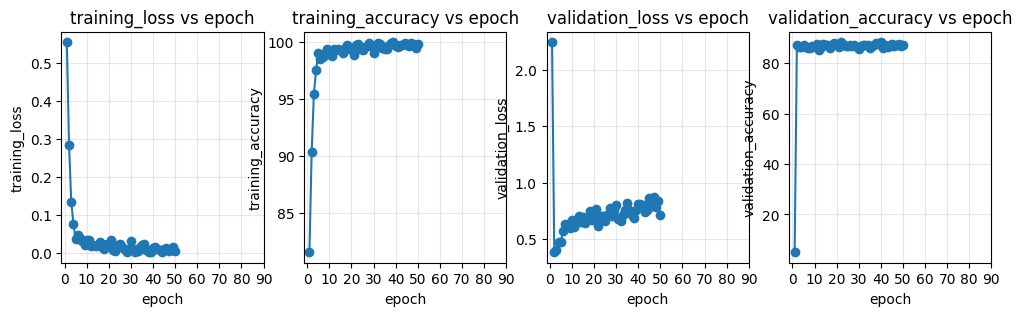

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].plot(range(1, len(training_loss)+1), training_loss, marker='o')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel("training_loss")
axes[0].set_title('training_loss vs epoch')
axes[0].set_xticks(list(10*i for i in range(10)))
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(training_acc)+1), training_acc, marker='o')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel("training_accuracy")
axes[1].set_title('training_accuracy vs epoch')
axes[1].set_xticks(list(10*i for i in range(10)))
axes[1].grid(True, alpha=0.3)

axes[2].plot(range(1, len(val_loss)+1), val_loss, marker='o')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel("validation_loss")
axes[2].set_title('validation_loss vs epoch')
axes[2].set_xticks(list(10*i for i in range(10)))
axes[2].grid(True, alpha=0.3)

axes[3].plot(range(1, len(val_accuracy)+1), val_accuracy, marker='o')
axes[3].set_xlabel('epoch')
axes[3].set_ylabel("validation_accuracy")
axes[3].set_title('validation_accuracy vs epoch')
axes[3].set_xticks(list(10*i for i in range(10)))
axes[3].grid(True, alpha=0.3)

In [10]:
import numpy as np
# training_loss = []
# training_acc = []
# val_loss = []
# val_accuracy = []
np.save('training_loss.npy', training_loss)
np.save('training_acc.npy', training_acc)
np.save('val_loss.npy', val_loss)
np.save('val_accuracy.npy', val_accuracy)

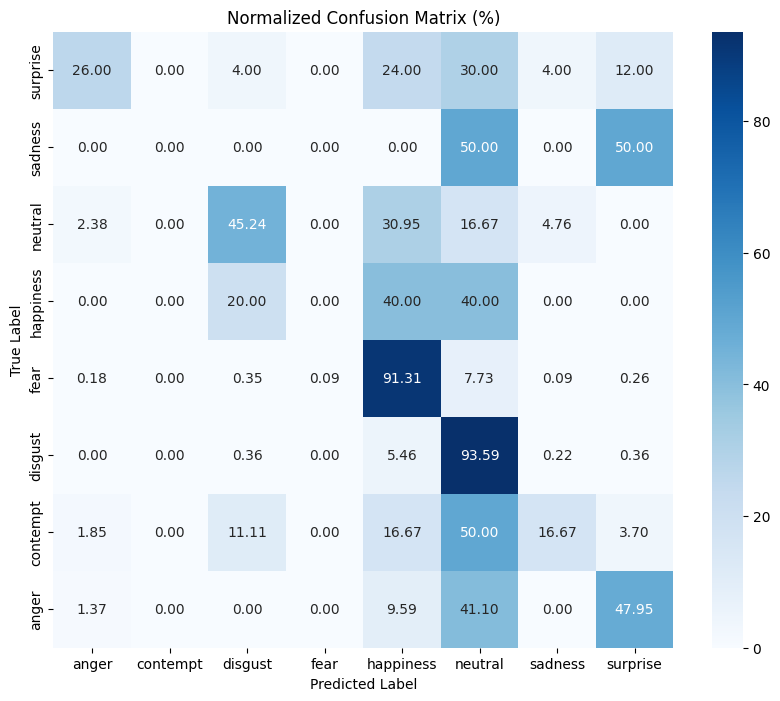


Per-class accuracy:
anger: 26.00%
contempt: 0.00%
disgust: 45.24%
fear: 0.00%
happiness: 91.31%
neutral: 93.59%
sadness: 16.67%
surprise: 47.95%

Weighted F1-Score: 0.8667


In [11]:
# confusion matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels[::-1])
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nPer-class accuracy:")
for i, label in enumerate(unique_labels):
    print(f"{label}: {cm_normalized[i, i]:.2f}%")

# f1-score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"\nWeighted F1-Score: {f1:.4f}")

In [12]:
examples_label = set()
examples = []

for images, labels in val_loader:

    for i in range(len(labels)):

        current_label = labels[i].item()

        if current_label not in examples_label:
            examples_label.add(current_label)

            img_tensor = images[i].unsqueeze(0)
            examples.append((img_tensor, current_label))
        if len(examples_label) == len(unique_labels):
            break
    if len(examples_label) == len(unique_labels):
        break

In [14]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

target_layers = [model.layer4[-1]]
visualizations = []

cam = GradCAM(model=model, target_layers=target_layers)
for image, label in examples:
    targets = [ClassifierOutputTarget(label)]
    grayscale_cam = cam(input_tensor=image, targets=targets)

    rgb_img = image.cpu().detach().numpy()

    rgb_img = np.squeeze(rgb_img, axis=0)
    rgb_img = np.transpose(rgb_img, (1, 2, 0))
    if rgb_img.shape[2] == 1:
        rgb_img = np.repeat(rgb_img, 3, axis=2)

    rgb_img = (rgb_img - rgb_img.min()) / \
        (rgb_img.max() - rgb_img.min() + 1e-8)

    visualizations.append(show_cam_on_image(
        rgb_img, grayscale_cam[0, :], use_rgb=True))

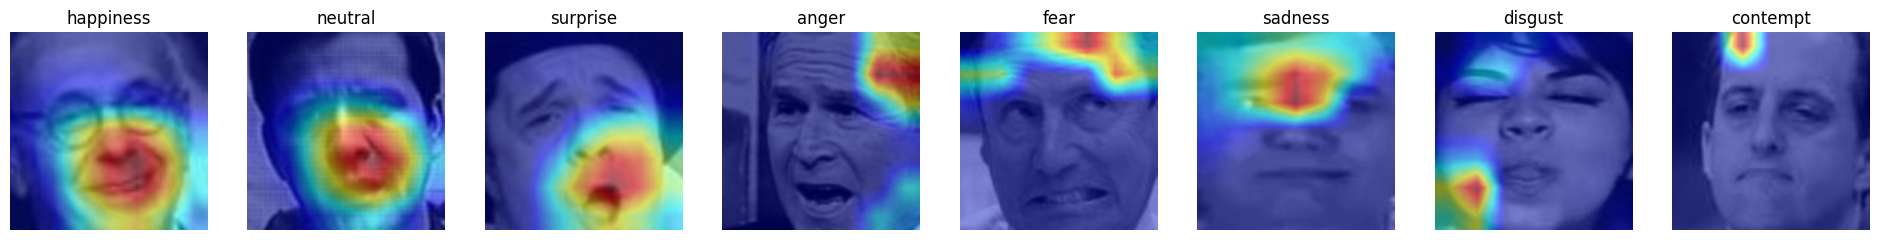

In [15]:
fig, ax = plt.subplots(1, 8, figsize=(24, 3))
for i in range(8):
    ax[i].imshow(visualizations[i])
    ax[i].axis('off')

    ax[i].set_title(f"{val_dataset.int_to_label[examples[i][1]]}")